In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from itertools import combinations
from sklearn.model_selection import train_test_split    
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn import svm
pd.options.display.max_columns=100
from sklearn.cluster import KMeans

In [2]:
def countryfinder(df1,x):
    return pd.concat([df1[df1['Country_x'].str.contains(x)],df1[df1['Country_y'].str.contains(x)]])
pd.options.display.max_columns=999
df = pd.read_csv('Untitled spreadsheet - Sheet1.csv')
df = df.drop('Independence Date', 1)
df = df.dropna()
borders = []
for i in df['Borders']:
    borders.append(i.split('/'))
within = []
for i in df['Within']:
    within.append(i.split('/'))
df['Borders'] = borders
df['Within'] = within
df2 = df.drop(0)
borders = []
for n in df.index:
    x = df.loc[n][0]
    for i in df.loc[n]['Borders']:
        borders.append([x,i])
borders = pd.DataFrame(borders)
borders = borders.drop([0,1]).reset_index().drop('index',1)
# quality of life indicators
cpi=pd.read_csv('CPI2020_GlobalTablesTS_210125.csv').drop('Region',1)
cpi = cpi.replace('-',np.nan)
edbi = pd.read_csv('edbiscores.csv')
edbi=edbi.replace('Russian Federation','Russia')
homicide = pd.read_csv('homicide.csv')
pfi = pd.read_csv('pfi.csv')[['Country','Score']]
pfi.columns = ['Country','2018 pfi']
pfi['2018 pfi'] = [float(x) for x in pfi['2018 pfi']]
homicide.columns = ['Country','Region','Subregion','Homicide Rate','Homicide County','Year','Source']
qol = pd.merge(cpi,pfi,on='Country',how='outer')
qol = pd.merge(qol,edbi,on='Country',how='outer')
qol = pd.merge(qol, homicide, on='Country',how='outer')
#qol['score'] = qol['2015 cpi'] / qol['2018 pfi'] * qol['DB 2019']
#GDP and Population
data = pd.read_csv('world_indicators_all_years.csv')
data = data[data['Time'] == '2016']
data = data.replace('Iran, Islamic Rep.','Iran').replace('Korea, Dem. People’s Rep.',"North Korea").replace('Lao PDR','Laos').replace('Korea, Rep.','South Korea').replace('Macedonia, FYR','Macedonia').replace('Myanmar','Myanmar (Burma)').replace('Russian Federation','Russia').replace('Slovak Republic','Slovakia').replace('Syrian Arab Republic','Syria').replace('Venezuela, RB','Venezuela').replace('Yemen, Rep.','Yemen')
data1 = data[['Country Name', 'Population, total [SP.POP.TOTL]','Population growth (annual %) [SP.POP.GROW]','GDP (current US$) [NY.GDP.MKTP.CD]', 'GDP per capita (current US$) [NY.GDP.PCAP.CD]']]
data1 = data1.replace('..',np.nan)
for x in [*data1.columns][1:]:
    data1[x] = [float(i) for i in data1[x]]
data1['Population, total [SP.POP.TOTL]'] = [float(n) for n in data1['Population, total [SP.POP.TOTL]']]
data1 = pd.merge(qol,data1,left_on='Country',right_on='Country Name',how='outer')
#trust=pd.read_csv('self-reported-trust-attitudes.csv')
#trust=trust[trust['Year']==2014]
#data1=pd.merge(data1,trust,left_on='Country',right_on='Entity').drop(['Entity','Code','Year_y'],1)
#treaties
schengen = ['Austria','Belgium','Czech Republic','Denmark','Estonia','Finland','France','Germany','Greece','Hungary','Iceland','Italy','Latvia','Liechtenstein','Lithuania','Luxembourg','Malta','Netherlands','Monaco','Norway','Poland','Portugal','San Marino','Slovakia','Slovenia','Spain','Sweden','Switzerland','Vatican City','United Kingdom','Ireland','Croatia']
common = ['Ireland','United Kingdom']
unionstate = ['Russia','Belarus']
peaceandfriendship = ['India','Bhutan','Nepal']
ca4 = ['El Salvador','Honduras','Guatemala','Nicaragua']
tasman = ['Australia','New Zealand']
andean = ['Bolivia','Ecuador','Colombia','Peru']
caricom = ['Antigua and Barbuda','Barbados', 'Belize', 'Dominica', 'Grenada','Guyana','Jamaica','Saint Kitts and Nevis','Saint Lucia','Saint Vincent and the Grenadines','Suriname','Trinidad and Tobago']
gcc = ['Saudi Arabia','Oman','Kuwait','United Arab Emirates','Bahrain']
eac = ['Kenya','Tanzania','Uganda','South Sudan','Rwanda','Burundi']
table = [schengen+common+unionstate+peaceandfriendship+ca4+tasman+andean+caricom+gcc+eac,['Schengen'] * len(schengen) + ['Common'] * len(common) + ['Union State'] * len(unionstate) + ['Peace and Friendship'] * len(peaceandfriendship) + ['Central America 4'] * len(ca4) + ['Trans-Tasman Agreement'] * len(tasman) + ['Andean Community'] * len(andean) + len(caricom) * ['Caricom'] + len(gcc) * ['Gulf Cooperation Council'] + ['East African Community'] * len(eac)]
treaties = pd.DataFrame(table).transpose()
treaties.columns = ['Country','Treaty']
notreaty = pd.DataFrame([*set(treaties['Country'])^set(data1['Country Name'])])
notreaty['Treaty'] = None
notreaty.columns = ['Country','Treaty']
treaties = pd.concat([notreaty,treaties])
data1 = pd.merge(data1,treaties,how='outer')
#colonies
british=['Afghanistan','Antigua and Barbuda','Australia','Bahamas','Bahrain','Barbados','Belize','Botswana','Brunei','Cameroon','Canada','Cyprus','Dominica','Egypt','Swaziland','Fiji','Gambia','Ghana','Grenada','Guyana','India','Iraq','Israel','Jamaica','Jordan','Kenya','Kiribati','Kuwait','Lesotho','Libya','Malawia','Malaysia','Maldives','Malta','Mauritius','Myanmar','Nauru','New Zealand','Nigeria','Oman','Pakistan','Palestine','Qatar','Saint Lucia','Saint Kitts and Nevis','Saint Vincent and the Grenadines','Seychelles','Sierra Leone','Singapore','Solomon Islands','South Africa','Sri Lanka','Sudan','Tanzania','Tonga','Trinidad and Tobago','Tuvalu','Uganda','United Arab Emirates','United States','Vanuatu','Yemen','Zambia','Zimbabwe','Ireland']
french=['Haiti','Suriname','Dominica','Saint Kitts and Nevis','Grenada','Saint Vincent and the Grenadines','Saint Lucia','Morocco','Algeria','Tunisia','Ivory Coast','Benin','Mali','Guinea','Mauritania','Niger','Senegal','Burkina Faso','Togo','Nigeria','Chad','Central African Republic','Congo','Gabon','Cameroon','Sao Tome and Principe','Madagascar','Mauritius','Djibouti','Seychelles','Comoros','Laos','Cambodia','Vietnam','Syria','Lebanon','Yemen','Vanuatu']
spanish=['Mexico','Guatemala','El Salvador','Nicaragua','Honduras','Costa Rica','Panama','Cuba','Dominican Republic','Colombia','Venezuela','Ecuador','Peru','Bolivia','Paraguay','Uruguay','Argentina','Chile','Equatorial Guinea','Philippines']
portuguese=['Brazil','Guinea Bissau','Angola','Mozambique','Timor Leste']
dutch=['Indonesia']
table=[british+french+spanish+portuguese+dutch,['British']*len(british)+['French']*len(french)+['Spanish']*len(spanish)+['Portuguese']*len(portuguese)+['Dutch']*len(dutch)]
colonies=pd.DataFrame(table).transpose()
colonies.columns=['Country','Colony']
nocolony = pd.DataFrame([*set(colonies['Country'])^set(data1['Country Name'])])
nocolony['Colony'] = None
nocolony.columns = ['Country','Colony']
colonies = pd.concat([nocolony,colonies])
data1 = pd.merge(data1,colonies,how='outer')
#Democracy Index from the EIU
democracy=pd.read_csv('democracyindex2019.csv')
democracy.columns=['Rank', 'Country', 'Democracy Score', 'Electoral process and pluralism',
       'Functioning of government', 'Political participation',
       'Political culture', 'Civil liberties', 'Regime type', 'Region[n 1]',
       'Changes from last year']
data1=pd.merge(data1,democracy,on='Country',how='outer')
for x in ['British','Spanish','French','Portuguese']:
    data1[x]=pd.to_numeric(data1['Colony'].replace(x,1), errors='coerce').fillna(0)
data1['Europe']=pd.to_numeric(data1['Region'].replace('Europe',1), errors='coerce').fillna(0)
data1=data1.drop_duplicates('Country')
#bring it all together
gini=pd.read_csv('gini.csv').iloc[:217].replace('..',np.nan)
data1['gini']=gini[['1990 [YR1990]', '2000 [YR2000]', '2010 [YR2010]', '2011 [YR2011]',
       '2012 [YR2012]', '2013 [YR2013]', '2014 [YR2014]', '2015 [YR2015]',
       '2016 [YR2016]', '2017 [YR2017]', '2018 [YR2018]', '2019 [YR2019]']].astype(float).mean(axis=1)
combos=list(combinations(data1['Country'],2))
borders=pd.DataFrame(combos).drop_duplicates()
test2=pd.merge(pd.merge(borders,data1.drop('Rank',1),left_on=0,right_on='Country Name',how='inner'),
               data1.drop('Rank',1),left_on=1,right_on='Country Name',how='inner')
#More statistics
test2.columns = ['Country_x', 'Country_y', 'C',
                 'ISO3_x', 'CPI score 2020_x', 'Rank 2020_x', 'Sources 2020_x', 'Standard error 2020_x', 'CPI score 2019_x',
                 'Rank 2019_x', 'Sources 2019_x', 'Standard error 2019_x', 'CPI score 2018_x', 'Rank 2018_x', 'Sources 2018_x',
                 'Standard error 2018_x', 'CPI score 2017_x', 'Rank 2017_x', 'Sources 2017_x', 'Standard error 2017_x',
                 'CPI score 2016_x', 'Sources 2016_x', 'Standard error 2016_x', 'CPI score 2015_x',
                 'Sources 2015_x', 'Standard error 2015_x', 'CPI score 2014_x', 'Sources 2014_x', 'Standard error 2014_x',
                 'CPI Score 2013_x', 'Sources 2013_x', 'Standard error 2013_x', 'CPI Score 2012_x', 'Sources 2012_x',
                 'Standard error 2012_x', '2018 pfi_x', 'DB_2018_x',
                 'DB_2019_x', 'Region_x', 'Subregion_x', 'Homicide Rate_x',
                 'Homicide County_x', 'Year_x', 'Source_x', 'Country Name_x', 
                 'Population_x','Population growth_x','GDP_x','GDP per capita_x', 'Treaty_x','Colony_x',
                 'Democracy Score_x', 'Electoral process and pluralism_x',
                 'Functioning of government_x', 'Political participation_x',
                 'Political culture_x', 'Civil liberties_x', 'Regime type_x',
                 'Region[n_x]_x', 'Changes from last year_x','British_x','Spanish_x','French_x','Portuguese_x',
                 'Europe_x', 'gini_x','Country',
                 'CPI score 2020_y', 'Rank 2020_y', 'Sources 2020_y', 'Standard error 2020_y', 'CPI score 2019_y', 'Rank 2019_y',
                 'Sources 2019_y', 'Standard error 2019_y', 'CPI score 2018_y', 'Rank 2018_y', 'Sources 2018_y',
                 'Standard error 2018_y', 'CPI score 2017_y', 'Rank 2017_y', 'Sources 2017_y', 'Standard error 2017_y',
                 'CPI score 2016_y', 'Sources 2016_y', 'Standard error 2016_y', 'CPI score 2015_y', 'Sources 2015_y',
                 'Standard error 2015_y', 'CPI score 2014_y', 'Sources 2014_y', 'Standard error 2014_y', 'CPI Score 2013_y',
                 'Sources 2013_y', 'Standard error 2013_y', 'CPI Score 2012_y', 'Sources 2012_y',
                 'Standard error 2012_y', '2018 pfi_y', 'DB_2018_y', 'DB_2019_y', 'Region_y',
                 'Subregion_y', 'Homicide Rate_y', 'Homicide County_y', 'Year_y',
                 'Source_y', 'score_y', 'Country Name_y','Population_y','Population growth_y','GDP_y',
                 'GDP per capita_y', 'Treaty_y','Colony_y',
                 'Democracy Score_y', 'Electoral process and pluralism_y',
                 'Functioning of government_y', 'Political participation_y',
                 'Political culture_y', 'Civil liberties_y', 'Regime type_y',
                 'Region[n_x]_y', 'Changes from last year_y', 'British_y','Spanish_y','French_y',
                 'Portuguese_y','Europe_y','gini_y']
test2['Population difference'] = test2['Population_x'] / test2['Population_y']
test2['Population growth difference'] = test2['Population growth_x']/ test2['Population growth_y']
test2['GDP difference'] = test2['GDP_x'] / test2['GDP_y']
test2['GDP per capita difference'] = test2['GDP per capita_x'] / test2['GDP per capita_y']
test2['Democracy Score difference']=test2['Democracy Score_x']/test2['Democracy Score_y']
test2['Electoral process and pluralism difference']=test2['Electoral process and pluralism_x']/test2['Electoral process and pluralism_y']
test2['Functioning of government difference']=test2['Functioning of government_x']/test2['Functioning of government_y']
test2['Political participation difference']=test2['Political participation_x']/test2['Political participation_y']
test2['Population difference'] = [1/x if x> 1 else x for x in test2['Population difference'] ]
test2['Population growth difference'] = [1/x if x> 1 else x for x in test2['Population growth difference']]
test2['GDP difference'] = [1/x if x> 1 else x for x in test2['GDP difference']]
test2['GDP per capita difference'] = [1/x if x> 1 else x for x in test2['GDP per capita difference']]
#test2 = pd.merge(test2,df2, left_on='Country_x', right_on='Name of country',how='outer').drop('Borders',1)
test2['GDP product'] = test2['GDP_x'] *test2['GDP_y']
test2['GDP per capita in both'] = (test2['GDP_x'] + test2['GDP_y']) / (test2['Population_x'] + test2['Population_y'])
test2 = test2.drop_duplicates('GDP product').reset_index()
df1 = test2
#df1['cpi difference'] = df1['2015 cpi_x'] / df1['2015 cpi_y']
#df1['cpi difference'] = [1/x if x> 1 for x in df1['cpi difference'] else x]
df1['GDP sum'] = df1['GDP_x']+df1['GDP_y']
#df1['cpi difference'] = [1/x if x> 1 else x for x in df1['cpi difference']]
df1['db difference'] = df1['DB_2019_x'] / df1['DB_2019_y']
df1['db difference'] = [1/x if x> 1 else x for x in df1['db difference']]
df1['pfi difference'] = df1['2018 pfi_x'] / df1['2018 pfi_y']
df1['pfi difference'] = [1/x if x> 1 else x for x in df1['pfi difference']]
#df1['homicide difference'] = df1['Homicide Rate_x'] / df1['Homicide Rate_y']
#df1['homicide difference'] = [1/x if x> 1 else x for x in df1['homicide difference']]
#df1['trust difference'] = df1['trust1'] / df1['trust2']
#df1['trust difference'] = [1/x if x> 1 else x for x in df1['pfi difference']]
#df1['Country Similarity'] = (df1['cpi difference']+df1['db difference']+df1['pfi difference']+df1['homicide difference']) /4
df1['average cpi'] = df1[['CPI score 2020_x','CPI score 2020_y']].mean(axis=1)
df1['average db'] = df1[['DB_2019_x','DB_2019_y']].mean(axis=1)
df1['average pfi'] = df1[['2018 pfi_x','2018 pfi_y']].mean(axis=1)
df1['average homicide'] = df1[['Homicide Rate_x','Homicide Rate_y']].mean(axis=1)
df1['average Democracy Score']=df1[['Democracy Score_x','Democracy Score_y']].mean(axis=1)
df1['average Electoral process and pluralism']=df1[['Electoral process and pluralism_x','Electoral process and pluralism_y']].mean(axis=1)
df1['average Functioning of Government']=df1[['Functioning of government_x','Functioning of government_y']].mean(axis=1)
df1['average Political participation']=df1[['Political participation_x','Political participation_y']].mean(axis=1)
df1['average Civil Liberties']=df1['Civil liberties_x']/df1['Civil liberties_y']
#df1['average trust'] = df1[['trust1','trust2']].mean(axis=1)
df1['Border Status'] = np.where(df1['Treaty_x'] == df1['Treaty_y'], 'Open', 'Closed')
df1['Combined Population'] = df1['Population_x'] + df1['Population_y']
df1['GDP per capita']=df1['GDP sum']/df1['Combined Population']
df1['viability'] = df1['average cpi'] * df1['average db'] / (df1['average pfi'] * df1['average homicide'])
df1['viability2'] = df1['average cpi'] * df1['average db'] *df1['GDP per capita']/ (df1['average pfi'] * df1['average homicide'])
df1 = df1.drop_duplicates('Combined Population').reset_index().drop('index',1)
df1['Status']=df1['Border Status'].replace('Open',1).replace('Closed',0)
df1=df1.replace(np.inf,np.nan)
df1['Same Region']=df1['Region_x']==df1['Region_y']
df1['Same Subregion']=df1['Subregion_x']==df1['Subregion_y']
df1['Same Colonial Power']=df1['Colony_x']==df1['Colony_y']
df1['Same Region']=df1['Same Region'].replace(False,0).replace(True,1)
df1['Same Subregion']=df1['Same Subregion'].replace(False,0).replace(True,1)
df1['Same Colonial Power']=df1['Same Colonial Power'].replace(False,0).replace(True,1)
test=df1.dropna(subset=['Country_x','Country_y','2018 pfi_x','2018 pfi_y','GDP_x','GDP_y',
                        'GDP per capita_x','GDP per capita_y',
                        'Homicide Rate_x','Homicide Rate_y',
                        'Democracy Score_x','Democracy Score_y',
                        'Status'])[['Country_x','Country_y',
                                    'GDP_x','GDP_y','GDP per capita_x','GDP per capita_y',
                                    'Homicide Rate_x','Homicide Rate_y','Democracy Score_x','Democracy Score_y','Population_x','Population_y','2018 pfi_x','2018 pfi_y','Status','Same Region','Same Subregion','Same Colonial Power','British_x','French_x','Spanish_x','Portuguese_x','British_y','Spanish_y','French_y','Portuguese_y','Europe_x','Europe_y']]
for x in ['2018 pfi','Homicide Rate','Democracy Score','Population']:
    test['Average '+x]=test[[x+'_x',x+'_y']].mean(axis=1)
test['Population']=test['Population_x']+test['Population_y']
test['GDP']=test['GDP_x']+test['GDP_y']
test['GDP per capita']=test['GDP']/test['Population']
test['worse pfi']=test[['2018 pfi_x','2018 pfi_y']].max(axis=1)
#test['worse DB']=test[['DB_2018_y','DB_2018_x']].min(axis=1)
test['worse homicide']=test[['Homicide Rate_y','Homicide Rate_x']].max(axis=1)
test['worse GDP per capita']=test[['GDP per capita_y','GDP per capita_x']].min(axis=1)
test['better pfi']=test[['2018 pfi_x','2018 pfi_y']].min(axis=1)
#test['better DB']=test[['DB_2018_y','DB_2018_x']].max(axis=1)
test['better homicide']=test[['Homicide Rate_y','Homicide Rate_x']].min(axis=1)
test['better GDP per capita']=test[['GDP per capita_y','GDP per capita_x']].max(axis=1)
test['worse Democracy Score']=test[['Democracy Score_y','Democracy Score_x']].min(axis=1)
test['better Democracy Score']=test[['Democracy Score_y','Democracy Score_x']].max(axis=1)
test['keep']=test['Country_x']==test['Country_y']
test=test[test['keep']==False]
test=test.drop('keep',1)
test

<ipython-input-2-67826e970337>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop('Independence Date', 1)
<ipython-input-2-67826e970337>:22: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  borders = borders.drop([0,1]).reset_index().drop('index',1)
<ipython-input-2-67826e970337>:24: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  cpi=pd.read_csv('CPI2020_GlobalTablesTS_210125.csv').drop('Region',1)
<ipython-input-2-67826e970337>:101: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  test2=pd.merge(pd.merge(borders,data1.drop('Rank',1),left_on=0,right_on='Country Name',how='inner'),
<ipython-input-2-67826e970337>:102: FutureWarning: In a futu

Country_x    Country_y         GDP_x         GDP_y  \
0                Denmark  New Zealand  3.068997e+11  1.849691e+11   
1                Denmark      Finland  3.068997e+11  2.385029e+11   
2            New Zealand      Finland  1.849691e+11  2.385029e+11   
3                Denmark    Singapore  3.068997e+11  2.969757e+11   
4            New Zealand    Singapore  1.849691e+11  2.969757e+11   
...                  ...          ...           ...           ...   
11930        Afghanistan        Yemen  1.946902e+10  2.731761e+10   
11931            Burundi        Yemen  3.007029e+09  2.731761e+10   
11932       Turkmenistan        Yemen  3.617989e+10  2.731761e+10   
11934  Equatorial Guinea        Yemen  1.068480e+10  2.731761e+10   
11935              Sudan        Yemen  9.558438e+10  2.731761e+10   

       GDP per capita_x  GDP per capita_y  Homicide Rate_x  \
0          53549.700671      39416.358733             0.98   
1          53549.700671      43402.863264             0.98   
2          39416.358733      43402.863264             0.99   
3          53549.700671      52962.491569             0.98   
4          39416.358733      52962.491569             0.99   
...                 ...               ...              ...   
11930        561.778746        990.334774             6.35   
11931        285.727442        990.334774             6.02   
11932       6389.334143        990.334774             4.22   
11934       8747.353473        990.334774             2.31   
11935       2415.038162        990.334774             5.16   

                 Homicide Rate_y  Democracy Score_x  Democracy Score_y  \
0      Australia and New Zealand               9.22               9.26   
1                Northern Europe               9.22               9.25   
2                Northern Europe               9.26               9.25   
3             South-Eastern Asia               9.22               6.02   
4             South-Eastern Asia               9.26               6.02   
...                          ...                ...                ...   
11930               Western Asia               2.85               1.95   
11931               Western Asia               2.15               1.95   
11932               Western Asia               1.72               1.95   
11934               Western Asia               1.92               1.95   
11935               Western Asia               2.70               1.95   

       Population_x  Population_y  2018 pfi_x  2018 pfi_y  Status  \
0         5731118.0     4692700.0       13.99         2.2       0   
1         5731118.0     5495096.0       13.99         3.0       1   
2         4692700.0     5495096.0       13.62         3.0       0   
3         5731118.0     5607283.0       13.99         2.1       0   
4         4692700.0     5607283.0       13.62         2.1       0   
...             ...           ...         ...         ...     ...   
11930    34656032.0    27584213.0       37.28         2.2       0   
11931    10524117.0    27584213.0       55.26         2.2       0   
11932     5662544.0    27584213.0       84.20         2.2       0   
11934     1221490.0    27584213.0       66.47         2.2       0   
11935    39578828.0    27584213.0       71.13         2.2       0   

       Same Region  Same Subregion  Same Colonial Power  British_x  French_x  \
0                0               0                    0        0.0       0.0   
1                0               0                    0        0.0       0.0   
2                0               0                    0        1.0       0.0   
3                0               0                    0        0.0       0.0   
4                0               0                    1        1.0       0.0   
...            ...             ...                  ...        ...       ...   
11930            0               0                    1        1.0       0.0   
11931            0               0                    0        0.0       0.0   
119

In [3]:
data1.columns=['Country', 'ISO3', 'CPI score 2020', 'Rank 2020', 'Sources 2020',
       'Standard error 2020', 'CPI score 2019', 'Rank 2019', 'Sources 2019',
       'Standard error 2019', 'CPI score 2018', 'Rank 2018', 'Sources 2018',
       'Standard error 2018', 'CPI score 2017', 'Rank 2017', 'Sources 2017',
       'Standard error 2017', 'CPI score 2016', 'Sources 2016',
       'Standard error 2016', 'CPI score 2015', 'Sources 2015',
       'Standard error 2015', 'CPI score 2014', 'Sources 2014',
       'Standard error 2014', 'CPI Score 2013', 'Sources 2013',
       'Standard error 2013', 'CPI Score 2012', 'Sources 2012',
       'Standard error 2012', '2018 pfi', 'DB 2018', 'DB 2019', 'Region',
       'Subregion', 'Homicide Rate', 'Homicide County', 'Year', 'Source',
       'Country Name', 'Population', 'Population growth',
       'GDP','GDP per capita', 'Treaty', 'Colony',
       'Rank', 'Democracy Score', 'Electoral process and pluralism',
       'Functioning of government', 'Political participation',
       'Political culture', 'Civil liberties', 'Regime type', 'Region[n 1]',
       'Changes from last year', 'British', 'Spanish', 'French', 'Portuguese',
       'Europe', 'gini']

In [4]:
test

Country_x    Country_y         GDP_x         GDP_y  \
0                Denmark  New Zealand  3.068997e+11  1.849691e+11   
1                Denmark      Finland  3.068997e+11  2.385029e+11   
2            New Zealand      Finland  1.849691e+11  2.385029e+11   
3                Denmark    Singapore  3.068997e+11  2.969757e+11   
4            New Zealand    Singapore  1.849691e+11  2.969757e+11   
...                  ...          ...           ...           ...   
11930        Afghanistan        Yemen  1.946902e+10  2.731761e+10   
11931            Burundi        Yemen  3.007029e+09  2.731761e+10   
11932       Turkmenistan        Yemen  3.617989e+10  2.731761e+10   
11934  Equatorial Guinea        Yemen  1.068480e+10  2.731761e+10   
11935              Sudan        Yemen  9.558438e+10  2.731761e+10   

       GDP per capita_x  GDP per capita_y  Homicide Rate_x  \
0          53549.700671      39416.358733             0.98   
1          53549.700671      43402.863264             0.98   
2          39416.358733      43402.863264             0.99   
3          53549.700671      52962.491569             0.98   
4          39416.358733      52962.491569             0.99   
...                 ...               ...              ...   
11930        561.778746        990.334774             6.35   
11931        285.727442        990.334774             6.02   
11932       6389.334143        990.334774             4.22   
11934       8747.353473        990.334774             2.31   
11935       2415.038162        990.334774             5.16   

                 Homicide Rate_y  Democracy Score_x  Democracy Score_y  \
0      Australia and New Zealand               9.22               9.26   
1                Northern Europe               9.22               9.25   
2                Northern Europe               9.26               9.25   
3             South-Eastern Asia               9.22               6.02   
4             South-Eastern Asia               9.26               6.02   
...                          ...                ...                ...   
11930               Western Asia               2.85               1.95   
11931               Western Asia               2.15               1.95   
11932               Western Asia               1.72               1.95   
11934               Western Asia               1.92               1.95   
11935               Western Asia               2.70               1.95   

       Population_x  Population_y  2018 pfi_x  2018 pfi_y  Status  \
0         5731118.0     4692700.0       13.99         2.2       0   
1         5731118.0     5495096.0       13.99         3.0       1   
2         4692700.0     5495096.0       13.62         3.0       0   
3         5731118.0     5607283.0       13.99         2.1       0   
4         4692700.0     5607283.0       13.62         2.1       0   
...             ...           ...         ...         ...     ...   
11930    34656032.0    27584213.0       37.28         2.2       0   
11931    10524117.0    27584213.0       55.26         2.2       0   
11932     5662544.0    27584213.0       84.20         2.2       0   
11934     1221490.0    27584213.0       66.47         2.2       0   
11935    39578828.0    27584213.0       71.13         2.2       0   

       Same Region  Same Subregion  Same Colonial Power  British_x  French_x  \
0                0               0                    0        0.0       0.0   
1                0               0                    0        0.0       0.0   
2                0               0                    0        1.0       0.0   
3                0               0                    0        0.0       0.0   
4                0               0                    1        1.0       0.0   
...            ...             ...                  ...        ...       ...   
11930            0               0                    1        1.0       0.0   
11931            0               0                    0        0.0       0.0   
119

In [5]:
data1[(data1['CPI score 2020']>70)&
      (data1['Region']!='Europe')&
      (data1['2018 pfi']<30)&
      (data1['GDP per capita']>20000)]

Country ISO3  CPI score 2020  Rank 2020  Sources 2020  \
1   New Zealand  NZL            88.0        1.0           8.0   
10    Australia  AUS            77.0       11.0           9.0   
11       Canada  CAN            77.0       11.0           8.0   
19        Japan  JPN            74.0       19.0           9.0   

    Standard error 2020  CPI score 2019  Rank 2019  Sources 2019  \
1                  1.48            87.0        1.0           8.0   
10                 1.05            77.0       12.0           9.0   
11                 1.77            77.0       12.0           8.0   
19                 2.02            73.0       20.0           9.0   

    Standard error 2019  CPI score 2018  Rank 2018  Sources 2018  \
1                  2.29            87.0        2.0           8.0   
10                 1.32            77.0       13.0           9.0   
11                 2.80            81.0        9.0           8.0   
19                 3.51            73.0       18.0           9.0   

    Standard error 2018  CPI score 2017  Rank 2017  Sources 2017  \
1                  2.44            89.0        1.0           8.0   
10                 1.27            77.0       13.0           9.0   
11                 2.16            82.0        8.0           8.0   
19                 2.85            73.0       20.0           9.0   

    Standard error 2017  CPI score 2016  Sources 2016  Standard error 2016  \
1                  2.40            90.0           7.0                 2.56   
10                 1.40            79.0           8.0                 1.27   
11                 1.49            82.0           7.0                 2.03   
19                 2.66            72.0           8.0                 3.02   

    CPI score 2015  Sources 2015  Standard error 2015  CPI score 2014  \
1             91.0           7.0                 2.32            91.0   
10            79.0           8.0                 1.50            80.0   
11            83.0           7.0                 1.63            81.0   
19            75.0           8.0                 2.96            76.0   

    Sources 2014  Standard error 2014  CPI Score 2013  Sources 2013  \
1            7.0                 2.28            91.0           7.0   
10           8.0                 1.31            81.0           8.0   
11           7.0                 2.45            81.0           7.0   
19           8.0                 3.16            74.0           9.0   

    Standard error 2013  CPI Score 2012  Sources 2012  Standard error 2012  \
1                   2.3            90.0           7.0                  2.2   
10                  1.5            85.0           8.0                  1.1   
11                  2.4            84.0           7.0                  2.2   
19                  2.4            74.0           9.0                  2.3   

    2018 pfi  DB 2018  DB 2019    Region                  Subregion  \
1      13.62    86.59    86.59   Oceania  Australia and New Zealand   
10     15.46    80.14    80.13   Oceania  Australia and New Zealand   
11     15.28    78.88    79.26  Americas           Northern America   
19     28.64    75.60    75.65      Asia               Eastern Asia   

    Homicide Rate  Homicide County    Year         Source Country Name  \
1            0.99             45.0  2014.0         NP/CTS  New Zealand   
10           0.94            227.0  2016.0  EUR/CTS/UNSDC    Australia   
11           1.68            611.0  2016.0    OAS/CTS/SDG       Canada   
19           0.28            362.0  2016.0        SDG/CTS        Japan   

     Population  Population growth           GDP  GDP per capita  \
1     4692700.0           2.088703  1.849691e+11    39416.358733   
10   24127159.0           1.410064  1.204616e+12    49927.819509   
11   36286425.0           1.213891  1.529760e+12    42157.927991   
19  126994511.0          -0.115284  4.940159e+12    38900.569306   

                    Treaty   Colony  Rank  Democracy Score  \
1   Trans-Tasman Agreemen

In [6]:
data1[(data1['CPI score 2015']>70)&
      (data1['Region']!='Europe')&
      (data1['2018 pfi']<30)]

Country ISO3  CPI score 2020  Rank 2020  Sources 2020  \
1     New Zealand  NZL            88.0        1.0           8.0   
10      Australia  AUS            77.0       11.0           9.0   
11         Canada  CAN            77.0       11.0           8.0   
12      Hong Kong  HKG            77.0       11.0           8.0   
19          Japan  JPN            74.0       19.0           9.0   
23        Uruguay  URY            71.0       21.0           7.0   
27  United States  USA            67.0       25.0           9.0   

    Standard error 2020  CPI score 2019  Rank 2019  Sources 2019  \
1                  1.48            87.0        1.0           8.0   
10                 1.05            77.0       12.0           9.0   
11                 1.77            77.0       12.0           8.0   
12                 1.79            76.0       16.0           8.0   
19                 2.02            73.0       20.0           9.0   
23                 1.72            71.0       21.0           7.0   
27                 2.49            69.0       23.0           9.0   

    Standard error 2019  CPI score 2018  Rank 2018  Sources 2018  \
1                  2.29            87.0        2.0           8.0   
10                 1.32            77.0       13.0           9.0   
11                 2.80            81.0        9.0           8.0   
12                 3.15            76.0       14.0           8.0   
19                 3.51            73.0       18.0           9.0   
23                 2.47            70.0       23.0           7.0   
27                 4.12            71.0       22.0           9.0   

    Standard error 2018  CPI score 2017  Rank 2017  Sources 2017  \
1                  2.44            89.0        1.0           8.0   
10                 1.27            77.0       13.0           9.0   
11                 2.16            82.0        8.0           8.0   
12                 2.47            77.0       13.0           7.0   
19                 2.85            73.0       20.0           9.0   
23                 2.73            70.0       23.0           7.0   
27                 3.25            75.0       16.0           9.0   

    Standard error 2017  CPI score 2016  Sources 2016  Standard error 2016  \
1                  2.40            90.0           7.0                 2.56   
10                 1.40            79.0           8.0                 1.27   
11                 1.49            82.0           7.0                 2.03   
12                 2.37            77.0           7.0                 2.62   
19                 2.66            72.0           8.0                 3.02   
23                 2.67            71.0           6.0                 2.68   
27                 3.24            74.0           9.0                 3.15   

    CPI score 2015  Sources 2015  Standard error 2015  CPI score 2014  \
1             91.0           7.0                 2.32            91.0   
10            79.0           8.0                 1.50            80.0   
11            83.0           7.0                 1.63            81.0   
12            75.0           7.0                 2.48            74.0   
19            75.0           8.0                 2.96            76.0   
23            74.0           6.0                 1.68            73.0   
27            76.0           8.0                 3.47            74.0   

    Sources 2014  Standard error 2014  CPI Score 2013  Sources 2013  \
1            7.0                 2.28            91.0           7.0   
10           8.0                 1.31            81.0           8.0   
11           7.0                 2.45            81.0           7.0   
12           7.0                 2.75            75.0           8.0   
19           8.0                 3.16            74.0           9.0   
23           6.0                 1.41            73.0           6.0   
27           8.0                 3.74            73.0           9.0   

    Standard error 2013  CPI Score 2012  Sources 2012  Stan

In [7]:
visas=pd.read_csv('visapoliciescompared.csv')

In [8]:
visas

Country Canada United States European Union Schengen Area  \
0                Andorra    ETA           ETA            NaN           Yes   
1    Antigua and Barbuda    NaN           NaN            NaN         ETIAS   
2              Argentina    NaN           NaN            NaN         ETIAS   
3              Australia    ETA           ETA            NaN         ETIAS   
4                Austria    ETA           ETA         Member        Member   
..                   ...    ...           ...            ...           ...   
116        United States   Free       Citizen            NaN         ETIAS   
117              Uruguay    NaN           NaN            NaN         ETIAS   
118              Vanuatu    NaN           NaN            NaN         ETIAS   
119         Vatican City    ETA           NaN            NaN           Yes   
120            Venezuela    NaN           NaN            NaN         ETIAS   

    Australia New Zealand Japan   Uruguay United Kingdom  
0    eVisitor       NzeTA  Free      Free           Free  
1         NaN         NaN   NaN       NaN           Free  
2         NaN       NzeTA  Free  MERCOSUR           Free  
3     Citizen        Free  Free      Free           Free  
4    eVisitor       NzeTA  Free      Free           Free  
..        ...         ...   ...       ...            ...  
116       ETA       NzeTA  Free      Free           Free  
117       NaN       NzeTA  Free   Citizen           Free  
118       NaN         NaN   NaN       NaN           Free  
119  eVisitor       NzeTA   NaN      Free           Free  
120       NaN         NaN   NaN      Free            NaN  

[121 rows x 10 columns]

In [9]:
visas.drop('European Union',1).dropna()

<ipython-input-9-bc339ab5c2cf>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  visas.drop('European Union',1).dropna()


Country   Canada United States Schengen Area  \
0           Andorra      ETA           ETA           Yes   
3         Australia      ETA           ETA         ETIAS   
4           Austria      ETA           ETA        Member   
7           Belgium      ETA           ETA        Member   
13           Canada  Citizen          Free         ETIAS   
18   Czech Republic      ETA           ETA        Member   
19          Denmark      ETA           ETA        Member   
23          Estonia      ETA           ETA        Member   
24          Finland      ETA           ETA        Member   
25           France      ETA           ETA        Member   
26          Germany      ETA           ETA        Member   
27           Greece      ETA           ETA        Member   
29          Hungary      ETA           ETA        Member   
30          Ireland      ETA           ETA            EU   
31            Italy      ETA           ETA        Member   
32           Latvia      ETA           ETA        Member   
33        Lithuania      ETA           ETA        Member   
34       Luxembourg      ETA           ETA        Member   
35            Malta      ETA           ETA        Member   
36      Netherlands      ETA           ETA        Member   
37           Poland      ETA           ETA        Member   
38         Portugal      ETA           ETA        Member   
40         Slovakia      ETA           ETA        Member   
41         Slovenia      ETA           ETA        Member   
42            Spain      ETA           ETA        Member   
43           Sweden      ETA           ETA        Member   
58          Iceland      ETA           ETA        Member   
65    Liechtenstein      ETA           ETA        Member   
74           Monaco      ETA           ETA           Yes   
78      New Zealand      ETA           ETA         ETIAS   
81           Norway      ETA           ETA        Member   
94       San Marino      ETA           ETA           Yes   
98        Singapore      ETA           ETA         ETIAS   
104     Switzerland      ETA           ETA        Member   
115  United Kingdom      ETA           ETA         ETIAS   
116   United States     Free       Citizen         ETIAS   

                  Australia New Zealand Japan Uruguay United Kingdom  
0                  eVisitor       NzeTA  Free    Free           Free  
3                   Citizen        Free  Free    Free           Free  
4                  eVisitor       NzeTA  Free    Free           Free  
7                  eVisitor       NzeTA  Free    Free           Free  
13                      ETA       NzeTA  Free    Free           Free  
18                 eVisitor       NzeTA  Free    Free           Free  
19                 eVisitor       NzeTA  Free    Free           Free  
23                 eVisitor       NzeTA  Free    Free           Free  
24                 eVisitor       NzeTA  Free    Free           Free  
25                 eVisitor       NzeTA  Free    Free           Free  
26                 eVisitor       NzeTA  Free    Free           Free  
27                 eVisitor       NzeTA  Free    Free           Free  
29                 eVisitor       NzeTA  Free    Free           Free  
30                 eVisitor       NzeTA  Free    Free           Free  
31                 eVisitor       NzeTA  Free    Free           Free  
32                 eVisitor       NzeTA  Free    Free           Free  
33                 eVisitor       NzeTA  Free    Free           Free  
34                 eVisitor       NzeTA  Free    Free           Free  
35                 eVisitor       NzeTA  Free    Free           Free  
36                 eVisitor       NzeTA  Free    Free           Free  
37                 eVisitor       NzeTA  Free    Free           Free  
38                 eVisitor       NzeTA  Free    Free           Free  
40                 eVisitor       NzeTA  Free    Free           Free  
41                 eVisitor       NzeTA  Free    Free           Free  
42              

In [10]:
visas[~visas['Schengen Area'].isin(['Member','EU','Yes'])].drop('European Union',1).dropna()

<ipython-input-10-051be52515c1>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  visas[~visas['Schengen Area'].isin(['Member','EU','Yes'])].drop('European Union',1).dropna()


Country   Canada United States Schengen Area  \
3         Australia      ETA           ETA         ETIAS   
13           Canada  Citizen          Free         ETIAS   
78      New Zealand      ETA           ETA         ETIAS   
98        Singapore      ETA           ETA         ETIAS   
115  United Kingdom      ETA           ETA         ETIAS   
116   United States     Free       Citizen         ETIAS   

                  Australia New Zealand Japan Uruguay United Kingdom  
3                   Citizen        Free  Free    Free           Free  
13                      ETA       NzeTA  Free    Free           Free  
78   Trans Tasman Agreement     Citizen  Free    Free           Free  
98                      ETA       NzeTA  Free    Free           Free  
115                eVisitor       NzeTA  Free    Free        Citizen  
116                     ETA       NzeTA  Free    Free           Free

In [11]:
visas.drop('European Union',1).dropna()

<ipython-input-11-bc339ab5c2cf>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  visas.drop('European Union',1).dropna()


Country   Canada United States Schengen Area  \
0           Andorra      ETA           ETA           Yes   
3         Australia      ETA           ETA         ETIAS   
4           Austria      ETA           ETA        Member   
7           Belgium      ETA           ETA        Member   
13           Canada  Citizen          Free         ETIAS   
18   Czech Republic      ETA           ETA        Member   
19          Denmark      ETA           ETA        Member   
23          Estonia      ETA           ETA        Member   
24          Finland      ETA           ETA        Member   
25           France      ETA           ETA        Member   
26          Germany      ETA           ETA        Member   
27           Greece      ETA           ETA        Member   
29          Hungary      ETA           ETA        Member   
30          Ireland      ETA           ETA            EU   
31            Italy      ETA           ETA        Member   
32           Latvia      ETA           ETA        Member   
33        Lithuania      ETA           ETA        Member   
34       Luxembourg      ETA           ETA        Member   
35            Malta      ETA           ETA        Member   
36      Netherlands      ETA           ETA        Member   
37           Poland      ETA           ETA        Member   
38         Portugal      ETA           ETA        Member   
40         Slovakia      ETA           ETA        Member   
41         Slovenia      ETA           ETA        Member   
42            Spain      ETA           ETA        Member   
43           Sweden      ETA           ETA        Member   
58          Iceland      ETA           ETA        Member   
65    Liechtenstein      ETA           ETA        Member   
74           Monaco      ETA           ETA           Yes   
78      New Zealand      ETA           ETA         ETIAS   
81           Norway      ETA           ETA        Member   
94       San Marino      ETA           ETA           Yes   
98        Singapore      ETA           ETA         ETIAS   
104     Switzerland      ETA           ETA        Member   
115  United Kingdom      ETA           ETA         ETIAS   
116   United States     Free       Citizen         ETIAS   

                  Australia New Zealand Japan Uruguay United Kingdom  
0                  eVisitor       NzeTA  Free    Free           Free  
3                   Citizen        Free  Free    Free           Free  
4                  eVisitor       NzeTA  Free    Free           Free  
7                  eVisitor       NzeTA  Free    Free           Free  
13                      ETA       NzeTA  Free    Free           Free  
18                 eVisitor       NzeTA  Free    Free           Free  
19                 eVisitor       NzeTA  Free    Free           Free  
23                 eVisitor       NzeTA  Free    Free           Free  
24                 eVisitor       NzeTA  Free    Free           Free  
25                 eVisitor       NzeTA  Free    Free           Free  
26                 eVisitor       NzeTA  Free    Free           Free  
27                 eVisitor       NzeTA  Free    Free           Free  
29                 eVisitor       NzeTA  Free    Free           Free  
30                 eVisitor       NzeTA  Free    Free           Free  
31                 eVisitor       NzeTA  Free    Free           Free  
32                 eVisitor       NzeTA  Free    Free           Free  
33                 eVisitor       NzeTA  Free    Free           Free  
34                 eVisitor       NzeTA  Free    Free           Free  
35                 eVisitor       NzeTA  Free    Free           Free  
36                 eVisitor       NzeTA  Free    Free           Free  
37                 eVisitor       NzeTA  Free    Free           Free  
38                 eVisitor       NzeTA  Free    Free           Free  
40                 eVisitor       NzeTA  Free    Free           Free  
41                 eVisitor       NzeTA  Free    Free           Free  
42              

In [12]:
scores=visas.drop('European Union',1).replace(['ETA',
                                        'ETIAS',
                                        'Citizen',
                                        'Free',
                                        'NzeTA',
                                        'Yes',
                                        'eVisitor',
                                        'Member',
                                        'MERCOSUR','Trans Tasman Agreement',
                                        'Freedom of Movement','Freedom of Movement',
                                         'EU'],1).replace('Guam and Northern Mariana Islands',np.nan)
scores.index=scores.Country
scores['cheapvisas']=scores.drop('Country',1).transpose().sum()
scores.sort_values('cheapvisas')

<ipython-input-12-8ef22d2bd364>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  scores=visas.drop('European Union',1).replace(['ETA',
<ipython-input-12-8ef22d2bd364>:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  scores['cheapvisas']=scores.drop('Country',1).transpose().sum()


Country  Canada  United States  Schengen Area  Australia  \
Country                                                                     
China              China     NaN            NaN            NaN        NaN   
Jamaica          Jamaica     NaN            NaN            NaN        NaN   
East Timor    East Timor     NaN            NaN            NaN        NaN   
Nauru              Nauru     NaN            NaN            NaN        NaN   
Namibia          Namibia     NaN            NaN            NaN        NaN   
...                  ...     ...            ...            ...        ...   
New Zealand  New Zealand     1.0            1.0            1.0        1.0   
Slovenia        Slovenia     1.0            1.0            1.0        1.0   
Denmark          Denmark     1.0            1.0            1.0        1.0   
San Marino    San Marino     1.0            1.0            1.0        1.0   
Andorra          Andorra     1.0            1.0            1.0        1.0   

             New Zealand  Japan  Uruguay  United Kingdom  cheapvisas  
Country                                                               
China                NaN    NaN      NaN             NaN         0.0  
Jamaica              NaN    NaN      1.0             NaN         1.0  
East Timor           NaN    NaN      NaN             1.0         1.0  
Nauru                NaN    NaN      NaN             1.0         1.0  
Namibia              NaN    NaN      NaN             1.0         1.0  
...                  ...    ...      ...             ...         ...  
New Zealand          1.0    1.0      1.0             1.0         8.0  
Slovenia             1.0    1.0      1.0             1.0         8.0  
Denmark              1.0    1.0      1.0             1.0         8.0  
San Marino           1.0    1.0      1.0             1.0         8.0  
Andorra              1.0    1.0      1.0             1.0         8.0  

[121 rows x 10 columns]

In [13]:
scores[scores['cheapvisas']==8]

Country  Canada  United States  Schengen Area  \
Country                                                                
Andorra                Andorra     1.0            1.0            1.0   
Australia            Australia     1.0            1.0            1.0   
Austria                Austria     1.0            1.0            1.0   
Belgium                Belgium     1.0            1.0            1.0   
Canada                  Canada     1.0            1.0            1.0   
Czech Republic  Czech Republic     1.0            1.0            1.0   
Denmark                Denmark     1.0            1.0            1.0   
Estonia                Estonia     1.0            1.0            1.0   
Finland                Finland     1.0            1.0            1.0   
France                  France     1.0            1.0            1.0   
Germany                Germany     1.0            1.0            1.0   
Greece                  Greece     1.0            1.0            1.0   
Hungary                Hungary     1.0            1.0            1.0   
Ireland                Ireland     1.0            1.0            1.0   
Italy                    Italy     1.0            1.0            1.0   
Latvia                  Latvia     1.0            1.0            1.0   
Lithuania            Lithuania     1.0            1.0            1.0   
Luxembourg          Luxembourg     1.0            1.0            1.0   
Malta                    Malta     1.0            1.0            1.0   
Netherlands        Netherlands     1.0            1.0            1.0   
Poland                  Poland     1.0            1.0            1.0   
Portugal              Portugal     1.0            1.0            1.0   
Slovakia              Slovakia     1.0            1.0            1.0   
Slovenia              Slovenia     1.0            1.0            1.0   
Spain                    Spain     1.0            1.0            1.0   
Sweden                  Sweden     1.0            1.0            1.0   
Iceland                Iceland     1.0            1.0            1.0   
Liechtenstein    Liechtenstein     1.0            1.0            1.0   
Monaco                  Monaco     1.0            1.0            1.0   
New Zealand        New Zealand     1.0            1.0            1.0   
Norway                  Norway     1.0            1.0            1.0   
San Marino          San Marino     1.0            1.0            1.0   
Singapore            Singapore     1.0            1.0            1.0   
Switzerland        Switzerland     1.0            1.0            1.0   
United Kingdom  United Kingdom     1.0            1.0            1.0   
United States    United States     1.0            1.0            1.0   

                Australia  New Zealand  Japan  Uruguay  United Kingdom  \
Country                                                                  
Andorra               1.0          1.0    1.0      1.0             1.0   
Australia             1.0          1.0    1.0      1.0             1.0   
Austria               1.0          1.0    1.0      1.0             1.0   
Belgium               1.0          1.0    1.0      1.0             1.0   
Canada                1.0          1.0    1.0      1.0             1.0   
Czech Republic        1.0          1.0    1.0      1.0             1.0   
Denmark               1.0          1.0    1.0      1.0             1.0   
Estonia               1.0          1.0    1.0      1.0             1.0   
Finland               1.0          1.0    1.0      1.0             1.0   
France                1.0          1.0    1.0      1.0             1.0   
Germany               1.0          1.0    1.0      1.0             1.0   
Greece                1.0          1.0    1.0      1.0             1.0   
Hungary               1.0          1.0    1.0      1.0             1.0   
Ireland               1.0          1.0    1.0      1.0             1.0   
Italy                 1.0          1.0    1.0      1.0             1.0   
Latvia                1.0   

In [14]:
scores.index=list(range(0,121))

In [15]:
data1=pd.merge(data1,scores.replace(np.nan,0),on='Country',how='outer')

In [16]:
data1

Country ISO3  CPI score 2020  Rank 2020  \
0                              Denmark  DNK            88.0        1.0   
1                          New Zealand  NZL            88.0        1.0   
2                              Finland  FIN            85.0        3.0   
3                            Singapore  SGP            85.0        3.0   
4                               Sweden  SWE            85.0        3.0   
..                                 ...  ...             ...        ...   
354                        Timor Leste  NaN             NaN        NaN   
355              Republic of the Congo  NaN             NaN        NaN   
356                         Micronesia  NaN             NaN        NaN   
357  Sovereign Military Order of Malta  NaN             NaN        NaN   
358               Trinidad and  Tobago  NaN             NaN        NaN   

     Sources 2020  Standard error 2020  CPI score 2019  Rank 2019  \
0             8.0                 1.78            87.0        1.0   
1             8.0                 1.48            87.0        1.0   
2             8.0                 1.75            86.0        3.0   
3             9.0                 1.20            85.0        4.0   
4             8.0                 1.30            85.0        4.0   
..            ...                  ...             ...        ...   
354           NaN                  NaN             NaN        NaN   
355           NaN                  NaN             NaN        NaN   
356           NaN                  NaN             NaN        NaN   
357           NaN                  NaN             NaN        NaN   
358           NaN                  NaN             NaN        NaN   

     Sources 2019  Standard error 2019  CPI score 2018  Rank 2018  \
0             8.0                 2.54            88.0        1.0   
1             8.0                 2.29            87.0        2.0   
2             8.0                 2.92            85.0        3.0   
3             9.0                 2.05            85.0        3.0   
4             8.0                 1.98            85.0        3.0   
..            ...                  ...             ...        ...   
354           NaN                  NaN             NaN        NaN   
355           NaN                  NaN             NaN        NaN   
356           NaN                  NaN             NaN        NaN   
357           NaN                  NaN             NaN        NaN   
358           NaN                  NaN             NaN        NaN   

     Sources 2018  Standard error 2018  CPI score 2017  Rank 2017  \
0             8.0                 2.63            88.0        2.0   
1             8.0                 2.44            89.0        1.0   
2             8.0                 2.74            85.0        3.0   
3             9.0                 1.98            84.0        6.0   
4             8.0                 2.02            84.0        6.0   
..            ...                  ...             ...        ...   
354           NaN                  NaN             NaN        NaN   
355           NaN                  NaN             NaN        NaN   
356           NaN                  NaN             NaN        NaN   
357           NaN                  NaN             NaN        NaN   
358           NaN                  NaN             NaN        NaN   

     Sources 2017  Standard error 2017  CPI score 2016  Sources 2016  \
0             8.0                 2.75            90.0           7.0   
1             8.0                 2.40            90.0           7.0   
2             8.0                 2.84            89.0           7.0   
3             9.0                 2.26            84.0           8.0   
4             8.0                 2.27            88.0           7.0   
..            ...                  ...             ...           ...   
354           NaN                  NaN             NaN           NaN   
355           NaN                  NaN             NaN           NaN   
356    

In [17]:
data1[scores.drop('cheapvisas',1).columns].corr()

<ipython-input-17-886dd95d8b7b>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data1[scores.drop('cheapvisas',1).columns].corr()


Canada  United States  Schengen Area  Australia  \
Canada          1.000000       0.739903       0.449382   0.823713   
United States   0.739903       1.000000       0.412399   0.771186   
Schengen Area   0.449382       0.412399       1.000000   0.419726   
Australia       0.823713       0.771186       0.419726   1.000000   
New Zealand     0.724484       0.613797       0.350841   0.763974   
Japan           0.633333       0.565073       0.347908   0.646537   
Uruguay         0.367356       0.262765       0.364403   0.456546   
United Kingdom  0.521749       0.471211       0.563201   0.479583   

                New Zealand     Japan   Uruguay  United Kingdom  
Canada             0.724484  0.633333  0.367356        0.521749  
United States      0.613797  0.565073  0.262765        0.471211  
Schengen Area      0.350841  0.347908  0.364403        0.563201  
Australia          0.763974  0.646537  0.456546        0.479583  
New Zealand        1.000000  0.603737  0.373013        0.404999  
Japan              0.603737  1.000000  0.347850        0.372678  
Uruguay            0.373013  0.347850  1.000000        0.225349  
United Kingdom     0.404999  0.372678  0.225349        1.000000

<ipython-input-18-b142c8c8c5a5>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  sns.heatmap(data1[scores.drop("cheapvisas",1).columns].corr())


<AxesSubplot:>

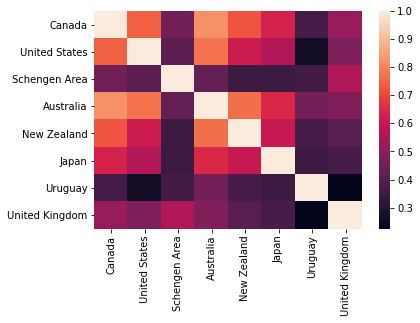

In [18]:
sns.heatmap(data1[scores.drop("cheapvisas",1).columns].corr())

In [19]:
scores[scores['Australia']!=scores['Canada']][['Country','Australia','Canada']]

Country  Australia  Canada
1     Antigua and Barbuda        NaN     NaN
2               Argentina        NaN     NaN
5                 Bahamas        NaN     1.0
6                Barbados        NaN     1.0
8                  Belize        NaN     NaN
..                    ...        ...     ...
113               Ukraine        NaN     NaN
114  United Arab Emirates        NaN     1.0
117               Uruguay        NaN     NaN
118               Vanuatu        NaN     NaN
120             Venezuela        NaN     NaN

[76 rows x 3 columns]

In [20]:
scores[(scores['Australia']==1)&(scores.replace(np.nan,0)['Canada']==0)][['Country','Australia','Canada']]

Country  Australia  Canada
67  Malaysia        1.0     NaN

In [21]:
scores[(scores['Canada']==1)&(scores.replace(np.nan,0)['Australia']==0)][['Country','Australia','Canada']]

Country  Australia  Canada
5                 Bahamas        NaN     1.0
6                Barbados        NaN     1.0
14                  Chile        NaN     1.0
59                 Israel        NaN     1.0
71                 Mexico        NaN     1.0
85       Papua New Guinea        NaN     1.0
93                  Samoa        NaN     1.0
99        Solomon Islands        NaN     1.0
105                Taiwan        NaN     1.0
114  United Arab Emirates        NaN     1.0

In [22]:
pd.DataFrame(scores.drop(['Country','cheapvisas'],1).sum()).sort_values(0)

<ipython-input-22-8d6f9089c62e>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  pd.DataFrame(scores.drop(['Country','cheapvisas'],1).sum()).sort_values(0)


0
United States   45.0
Australia       46.0
Canada          55.0
New Zealand     62.0
Japan           66.0
Uruguay         83.0
United Kingdom  88.0
Schengen Area   94.0

In [23]:
data1[(data1['Schengen Area']!=1)&
     (data1['2018 pfi']<30)].dropna(subset=['CPI score 2020']).sort_values('CPI score 2020')

Country ISO3  CPI score 2020  Rank 2020  Sources 2020  \
161              Comoros  COM            21.0      160.0           4.0   
152           Madagascar  MDG            25.0      149.0           8.0   
143     Papua New Guinea  PNG            27.0      142.0           6.0   
136   Dominican Republic  DOM            28.0      137.0           7.0   
134           Mauritania  MRT            29.0      134.0           6.0   
130               Malawi  MWI            30.0      129.0           9.0   
122                Niger  NER            32.0      123.0           7.0   
119         Sierra Leone  SLE            33.0      117.0           8.0   
111             Mongolia  MNG            35.0      111.0           9.0   
107               Kosovo  KSV            36.0      104.0           6.0   
89   Trinidad and Tobago  TTO            40.0       86.0           7.0   
85          Burkina Faso  BFA            40.0       86.0           8.0   
83                Guyana  GUY            41.0       83.0           5.0   
84               Lesotho  LSO            41.0       83.0           6.0   
74                 Ghana  GHA            43.0       75.0           9.0   
72          South Africa  ZAF            44.0       69.0           8.0   
70               Jamaica  JAM            44.0       69.0           7.0   
67               Senegal  SEN            45.0       67.0           9.0   
59               Armenia  ARM            49.0       60.0           6.0   
57               Namibia  NAM            51.0       57.0           7.0   
40            Cabo Verde  CPV            58.0       41.0           4.0   
34              Botswana  BWA            60.0       35.0           7.0   

     Standard error 2020  CPI score 2019  Rank 2019  Sources 2019  \
161                 5.75            25.0      153.0           4.0   
152                 1.51            24.0      158.0           8.0   
143                 1.62            28.0      137.0           6.0   
136                 1.91            28.0      137.0           7.0   
134                 1.60            28.0      137.0           6.0   
130                 1.16            31.0      123.0           9.0   
122                 1.20            32.0      120.0           7.0   
119                 2.42            33.0      119.0           8.0   
111                 0.71            35.0      106.0           9.0   
107                 0.68            36.0      101.0           5.0   
89                  3.73            40.0       85.0           7.0   
85                  1.62            40.0       85.0           8.0   
83                  3.54            40.0       85.0           5.0   
84                  3.24            40.0       85.0           6.0   
74                  1.52            41.0       80.0           9.0   
72                  2.17            44.0       70.0           8.0   
70                  3.34            43.0       74.0           7.0   
67                  1.33            45.0       66.0           9.0   
59                  3.50            42.0       77.0           6.0   
57                  1.88            52.0       56.0           7.0   
40                  3.72            58.0       41.0           4.0   
34                  2.88            61.0       34.0           7.0   

     Standard error 2019  CPI score 2018  Rank 2018  Sources 2018  \
161                 8.90            27.0      144.0           4.0   
152                 2.48            25.0      152.0           7.0   
143                 2.38            28.0      138.0           6.0   
136                 2.70            30.0      129.0           7.0   
134                 2.73            27.0      144.0           6.0   
130                 1.78            32.0      120.0           9.0   
122                 1.72            34.0      114.0           6.0   
119                 3.47            30.0      129.0           9.0   
111                 1.89            37.0       93.0           9.0   
107                 0.81            

In [24]:
data1[(data1['Schengen Area']!=1)&
     (data1['2018 pfi']<30)&(data1['CPI score 2020']>60)].dropna(subset=['CPI score 2020']).sort_values('GDP per capita')

Empty DataFrame
Columns: [Country, ISO3, CPI score 2020, Rank 2020, Sources 2020, Standard error 2020, CPI score 2019, Rank 2019, Sources 2019, Standard error 2019, CPI score 2018, Rank 2018, Sources 2018, Standard error 2018, CPI score 2017, Rank 2017, Sources 2017, Standard error 2017, CPI score 2016, Sources 2016, Standard error 2016, CPI score 2015, Sources 2015, Standard error 2015, CPI score 2014, Sources 2014, Standard error 2014, CPI Score 2013, Sources 2013, Standard error 2013, CPI Score 2012, Sources 2012, Standard error 2012, 2018 pfi, DB 2018, DB 2019, Region, Subregion, Homicide Rate, Homicide County, Year, Source, Country Name, Population, Population growth, GDP, GDP per capita, Treaty, Colony, Rank, Democracy Score, Electoral process and pluralism, Functioning of government, Political participation, Political culture, Civil liberties, Regime type, Region[n 1], Changes from last year, British, Spanish, French, Portuguese, Europe, gini, Canada, United States, Schengen Area, Australia, New Zealand, Japan, Uruguay, United Kingdom, cheapvisas]
Index: []

In [25]:
data1[(data1['United States']!=1)&
     (data1['2018 pfi']<30)&(data1['CPI score 2020']>60)].dropna(subset=['CPI score 2020']).sort_values('GDP per capita')

Country ISO3  CPI score 2020  Rank 2020  Sources 2020  \
21    Uruguay  URY            71.0       21.0           7.0   
12  Hong Kong  HKG            77.0       11.0           8.0   

    Standard error 2020  CPI score 2019  Rank 2019  Sources 2019  \
21                 1.72            71.0       21.0           7.0   
12                 1.79            76.0       16.0           8.0   

    Standard error 2019  CPI score 2018  Rank 2018  Sources 2018  \
21                 2.47            70.0       23.0           7.0   
12                 3.15            76.0       14.0           8.0   

    Standard error 2018  CPI score 2017  Rank 2017  Sources 2017  \
21                 2.73            70.0       23.0           7.0   
12                 2.47            77.0       13.0           7.0   

    Standard error 2017  CPI score 2016  Sources 2016  Standard error 2016  \
21                 2.67            71.0           6.0                 2.68   
12                 2.37            77.0           7.0                 2.62   

    CPI score 2015  Sources 2015  Standard error 2015  CPI score 2014  \
21            74.0           6.0                 1.68            73.0   
12            75.0           7.0                 2.48            74.0   

    Sources 2014  Standard error 2014  CPI Score 2013  Sources 2013  \
21           6.0                 1.41            73.0           6.0   
12           7.0                 2.75            75.0           8.0   

    Standard error 2013  CPI Score 2012  Sources 2012  Standard error 2012  \
21                  1.4            72.0           6.0                  1.5   
12                  2.4            77.0           8.0                  1.9   

    2018 pfi  DB 2018  DB 2019    Region      Subregion  Homicide Rate  \
21     15.56    62.26     62.6  Americas  South America           7.69   
12     29.04      NaN      NaN      Asia   Eastern Asia           0.38   

    Homicide County    Year        Source Country Name  Population  \
21            265.0  2016.0       MOI/CTS      Uruguay   3444006.0   
12             28.0  2016.0  UNSDC/NP/CTS          NaN         NaN   

    Population growth           GDP  GDP per capita Treaty   Colony  Rank  \
21           0.362269  5.241972e+10    15220.566025   None  Spanish  15.0   
12                NaN           NaN             NaN    NaN      NaN  75.0   

    Democracy Score  Electoral process and pluralism  \
21             8.38                            10.00   
12             6.02                             3.58   

    Functioning of government  Political participation  Political culture  \
21                       8.57                     6.11                7.5   
12                       4.36                     6.11                7.5   

    Civil liberties       Regime type         Region[n 1]  \
21             9.71    Full democracy       Latin America   
12             8.53  Flawed democracy  Asia & Australasia   

    Changes from last year  British  Spanish  French  Portuguese  Europe  \
21          Score: \nRank:      0.0      1.0     0.0         0.0     0.0   
12  Score:  0.13\nRank:  2      0.0      0.0     0.0         0.0     0.0   

         gini  Canada  United States  Schengen Area  Australia  New Zealand  \
21  47.466667     0.0            0.0            1.0        0.0          1.0   
12        NaN     1.0            0.0            1.0        1.0          1.0   

    Japan  Uruguay  United Kingdom  cheapvisas  
21    1.0      1.0             1.0         5.0  
12    1.0      1.0             1.0         7.0

In [26]:
data1.isnull().sum()

Country             1
ISO3              179
CPI score 2020    179
Rank 2020         179
Sources 2020      179
                 ... 
New Zealand       238
Japan             238
Uruguay           238
United Kingdom    238
cheapvisas        238
Length: 74, dtype: int64

In [43]:
 def regression(y, df,results=False):
    import statsmodels.api as sm
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_squared_error
    from sklearn.model_selection import train_test_split
    X = df.drop([y],1)
    y = df[y]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5)
    results=df
    model = sm.OLS(y_train, X_train)
    model = model.fit()
    predictions = model.predict(X_test)
    model = sm.OLS(y_test, X_test)
    model = model.fit()
    predictions=pd.concat([predictions,model.predict(X_train)])
    if results is True:
        return df
    else:
        # Plot the model
        plt.figure(figsize=(8,6))
        plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
        plt.xlabel("Predicted Values - $\hat{y}$")
        plt.ylabel("Actual Values - $y$")
        plt.show()
        print("MSE:", mean_squared_error(y, predictions))
        return model.summary()

In [44]:
data1.shape

(359, 74)

In [45]:
data1.dropna(subset=['CPI score 2020']).select_dtypes(float).dropna().columns

Index(['CPI score 2020', 'Rank 2020', 'Sources 2020', 'Standard error 2020',
       'CPI score 2019', 'Rank 2019', 'Sources 2019', 'Standard error 2019',
       'CPI score 2018', 'Rank 2018', 'Sources 2018', 'Standard error 2018',
       'CPI score 2017', 'Rank 2017', 'Sources 2017', 'Standard error 2017',
       'CPI score 2016', 'Sources 2016', 'Standard error 2016',
       'CPI score 2015', 'Sources 2015', 'Standard error 2015',
       'CPI score 2014', 'Sources 2014', 'Standard error 2014',
       'CPI Score 2013', 'Sources 2013', 'Standard error 2013',
       'CPI Score 2012', 'Sources 2012', 'Standard error 2012', '2018 pfi',
       'DB 2018', 'DB 2019', 'Homicide Rate', 'Homicide County', 'Year',
       'Population', 'Population growth', 'GDP', 'GDP per capita', 'Rank',
       'Democracy Score', 'Electoral process and pluralism',
       'Functioning of government', 'Political participation',
       'Political culture', 'Civil liberties', 'British', 'Spanish', 'French',
       'P

In [46]:
 def RFRegressor(y, df):
    X = df.drop([y], 1)
    y = df[y]
    from sklearn.ensemble import RandomForestRegressor
    rf = RandomForestRegressor()
    rf.fit(X, y)
    names = X.dtypes.index
    print("Features sorted by their score:")
    print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
                 reverse=True))

In [47]:
RFRegressor('United States',data1.dropna(subset=['CPI score 2020']).select_dtypes(float).dropna().drop(['cheapvisas',
                                                                                              'Australia',
                                                                                              'Canada'],1))

Features sorted by their score:
[(0.2562, 'Electoral process and pluralism'), (0.1037, 'CPI score 2016'), (0.0859, '2018 pfi'), (0.0533, 'DB 2018'), (0.0445, 'GDP per capita'), (0.0443, 'CPI score 2018'), (0.042, 'DB 2019'), (0.0386, 'Rank 2018'), (0.0334, 'Rank 2017'), (0.0325, 'Rank'), (0.0265, 'Political participation'), (0.0261, 'gini'), (0.0247, 'Europe'), (0.0162, 'Democracy Score'), (0.012, 'CPI score 2020'), (0.0112, 'Homicide Rate'), (0.011, 'CPI score 2017'), (0.0096, 'Sources 2012'), (0.0096, 'CPI Score 2013'), (0.0094, 'Civil liberties'), (0.0091, 'CPI score 2014'), (0.008, 'Sources 2013'), (0.0076, 'CPI score 2019'), (0.0075, 'Standard error 2019'), (0.0073, 'GDP'), (0.0069, 'Sources 2016'), (0.0063, 'Population growth'), (0.0062, 'Standard error 2017'), (0.0061, 'Standard error 2014'), (0.0052, 'Standard error 2018'), (0.0047, 'Rank 2020'), (0.0046, 'Standard error 2013'), (0.0045, 'Sources 2015'), (0.0043, 'Japan'), (0.0043, 'CPI Score 2012'), (0.0041, 'Sources 2017'), (

<ipython-input-47-78c3e14c0224>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  RFRegressor('United States',data1.dropna(subset=['CPI score 2020']).select_dtypes(float).dropna().drop(['cheapvisas',
<ipython-input-46-cae59610dc50>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df.drop([y], 1)


<ipython-input-43-bccd517f1c62>:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df.drop([y],1)


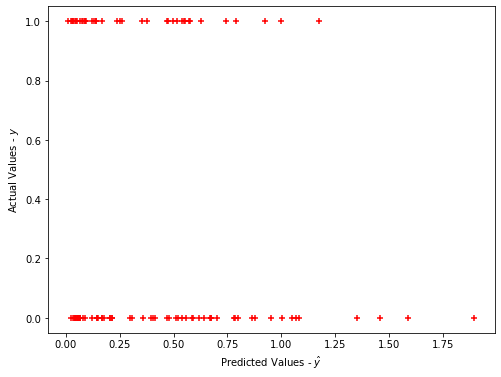

MSE: 0.4464552394249745


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          United States   R-squared (uncentered):                   0.781
Model:                            OLS   Adj. R-squared (uncentered):              0.773
Method:                 Least Squares   F-statistic:                              89.30
Date:                Mon, 20 Sep 2021   Prob (F-statistic):                    3.14e-17
Time:                        17:35:03   Log-Likelihood:                         -8.0887
No. Observations:                  52   AIC:                                      20.18
Df Residuals:                      50   BIC:                                      24.08
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
GDP per capita   1.48e-05   2.15e-06      6.899      0.000    1.05e-05    1.91e-05
Europe             0.4081      0.087      4.716      0.000       0.234       0.582
==============================================================================
Omnibus:                       11.258   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.868
Skew:                           0.896   Prob(JB):                      0.00265
Kurtosis:                       4.506   Cond. No.                     5.14e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 5.14e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [48]:
#target=data1.dropna(subset=['score']).select_dtypes(float).dropna()
regression('United States',
           data1[['United States','GDP per capita','Europe']].dropna(),
           results=False)

In [50]:
data1[['United States','GDP per capita','Europe']].dropna().shape

(103, 3)

In [51]:
data1[(data1['United States']==0)&
      (data1['CPI score 2020']>70)].dropna(subset=['CPI score 2020']).sort_values('GDP per capita', ascending=False)

Country ISO3  CPI score 2020  Rank 2020  Sources 2020  \
20  United Arab Emirates  ARE            71.0       21.0           8.0   
21               Uruguay  URY            71.0       21.0           7.0   
12             Hong Kong  HKG            77.0       11.0           8.0   

    Standard error 2020  CPI score 2019  Rank 2019  Sources 2019  \
20                 3.23            71.0       21.0           8.0   
21                 1.72            71.0       21.0           7.0   
12                 1.79            76.0       16.0           8.0   

    Standard error 2019  CPI score 2018  Rank 2018  Sources 2018  \
20                 5.13            70.0       23.0           8.0   
21                 2.47            70.0       23.0           7.0   
12                 3.15            76.0       14.0           8.0   

    Standard error 2018  CPI score 2017  Rank 2017  Sources 2017  \
20                 4.56            71.0       21.0           7.0   
21                 2.73            70.0       23.0           7.0   
12                 2.47            77.0       13.0           7.0   

    Standard error 2017  CPI score 2016  Sources 2016  Standard error 2016  \
20                 6.26            66.0           7.0                 5.70   
21                 2.67            71.0           6.0                 2.68   
12                 2.37            77.0           7.0                 2.62   

    CPI score 2015  Sources 2015  Standard error 2015  CPI score 2014  \
20            70.0           7.0                 5.07            70.0   
21            74.0           6.0                 1.68            73.0   
12            75.0           7.0                 2.48            74.0   

    Sources 2014  Standard error 2014  CPI Score 2013  Sources 2013  \
20           7.0                 5.14            69.0           7.0   
21           6.0                 1.41            73.0           6.0   
12           7.0                 2.75            75.0           8.0   

    Standard error 2013  CPI Score 2012  Sources 2012  Standard error 2012  \
20                  4.7            68.0           7.0                  4.3   
21                  1.4            72.0           6.0                  1.5   
12                  2.4            77.0           8.0                  1.9   

    2018 pfi  DB 2018  DB 2019    Region      Subregion  Homicide Rate  \
20     40.86    78.91    81.28      Asia   Western Asia           0.89   
21     15.56    62.26    62.60  Americas  South America           7.69   
12     29.04      NaN      NaN      Asia   Eastern Asia           0.38   

    Homicide County    Year        Source          Country Name  Population  \
20             83.0  2016.0           CTS  United Arab Emirates   9269612.0   
21            265.0  2016.0       MOI/CTS               Uruguay   3444006.0   
12             28.0  2016.0  UNSDC/NP/CTS                   NaN         NaN   

    Population growth           GDP  GDP per capita                    Treaty  \
20           1.251759  3.487433e+11    37622.207456  Gulf Cooperation Council   
21           0.362269  5.241972e+10    15220.566025                      None   
12                NaN           NaN             NaN                       NaN   

     Colony   Rank  Democracy Score  Electoral process and pluralism  \
20  British  145.0             2.76                             0.00   
21  Spanish   15.0             8.38                            10.00   
12      NaN   75.0             6.02                             3.58   

    Functioning of government  Political participation  Political culture  \
20                       3.93                     2.22                5.0   
21                       8.57                     6.11                7.5   
12                       4.36                     6.11                7.5   

    Civil liberties       Regime type                 Region[n 1]  \
20             2.65     Authoritarian  Middle East & North Africa   
21             9.71   

In [52]:
data1[(data1['United States']==0)&
      (data1['CPI score 2020']>50)].dropna(subset=['CPI score 2020']).sort_values('GDP per capita', ascending=False)

Country ISO3  CPI score 2020  Rank 2020  \
30                             Qatar  QAT            63.0       30.0   
20              United Arab Emirates  ARE            71.0       21.0   
36                            Israel  ISR            60.0       35.0   
42                            Cyprus  CYP            57.0       42.0   
55                      Saudi Arabia  SAU            53.0       52.0   
28                          Barbados  BRB            64.0       29.0   
21                           Uruguay  URY            71.0       21.0   
26                        Seychelles  SYC            66.0       27.0   
49                              Oman  OMN            54.0       49.0   
41                        Costa Rica  CRI            57.0       42.0   
51                           Grenada  GRD            53.0       52.0   
54                         Mauritius  MUS            53.0       52.0   
56                          Malaysia  MYS            51.0       57.0   
47                          Dominica  DMA            55.0       48.0   
34                          Botswana  BWA            60.0       35.0   
57                           Namibia  NAM            51.0       57.0   
44                           Georgia  GEO            56.0       45.0   
12                         Hong Kong  HKG            77.0       11.0   
39  Saint Vincent and the Grenadines  VCT            59.0       40.0   
46                       Saint Lucia  LCA            56.0       45.0   

    Sources 2020  Standard error 2020  CPI score 2019  Rank 2019  \
30           7.0                 5.35            62.0       30.0   
20           8.0                 3.23            71.0       21.0   
36           7.0                 1.34            60.0       35.0   
42           7.0                 3.19            58.0       41.0   
55           7.0                 5.36            53.0       51.0   
28           4.0                 5.47            62.0       30.0   
21           7.0                 1.72            71.0       21.0   
26           4.0                 2.97            66.0       27.0   
49           6.0                 7.47            52.0       56.0   
41           7.0                 2.58            56.0       44.0   
51           3.0                 3.48            53.0       51.0   
54           6.0                 1.54            52.0       56.0   
56           9.0                 1.62            53.0       51.0   
47           3.0                 1.98            55.0       48.0   
34           7.0                 2.88            61.0       34.0   
57           7.0                 1.88            52.0       56.0   
44           5.0                 3.15            56.0       44.0   
12           8.0                 1.79            76.0       16.0   
39           3.0                 4.02            59.0       39.0   
46           3.0                 4.17            55.0       48.0   

    Sources 2019  Standard error 2019  CPI score 2018  Rank 2018  \
30           7.0                 8.00            62.0       33.0   
20           8.0                 5.13            70.0       23.0   
36           7.0                 1.99            61.0       34.0   
42           7.0                 3.41            59.0       38.0   
55           7.0                 7.56            49.0       58.0   
28           4.0                 6.06            68.0       25.0   
21           7.0                 2.47            70.0       23.0   
26           4.0                 3.40            66.0       28.0   
49           6.0                 9.78            52.0       53.0   
41           7.0                 3.97            56.0       48.0   
51           3.0                 4.37            52.0       53.0   
54           6.0                 3.12            51.0       56.0   
56           9.0                 2.29            47.0       61.0   
47           3.0                 2.16            57.0       45.0   
34           7.0                 3.73            61.0       34.0   

In [53]:
cpimin=min(data1[data1['United States']==1]['CPI score 2020'])
pfimin=max(data1[data1['United States']==1]['2018 pfi'])
gdpmin=min(data1[data1['United States']==1]['GDP per capita'])
democracymin=min(data1[data1['United States']==1]['Democracy Score'])
data1[(data1['CPI score 2020']>cpimin)&
     (data1['2018 pfi']<pfimin)&
     (data1['GDP per capita']>gdpmin)&
      (data1['Democracy Score']>democracymin)&
     (data1['United States']==0)][['Country','CPI score 2020','2018 pfi','GDP per capita','Democracy Score','United States']]

Country  CPI score 2020  2018 pfi  GDP per capita  Democracy Score  \
21     Uruguay            71.0     15.56    15220.566025             8.38   
34    Botswana            60.0     25.29     6924.149775             7.81   
36      Israel            60.0     30.26    37175.742029             7.86   
41  Costa Rica            57.0     14.01    11824.638102             8.13   
42      Cyprus            57.0     19.85    23324.201735             7.59   
54   Mauritius            53.0     26.45     9630.944028             8.22   
56    Malaysia            51.0     47.41     9508.237750             7.16   
57     Namibia            51.0     20.24     4414.978947             6.43   
63     Croatia            47.0     28.94    12160.110629             6.57   

    United States  
21            0.0  
34            0.0  
36            0.0  
41            0.0  
42            0.0  
54            0.0  
56            0.0  
57            0.0  
63            0.0

<ipython-input-43-bccd517f1c62>:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df.drop([y],1)


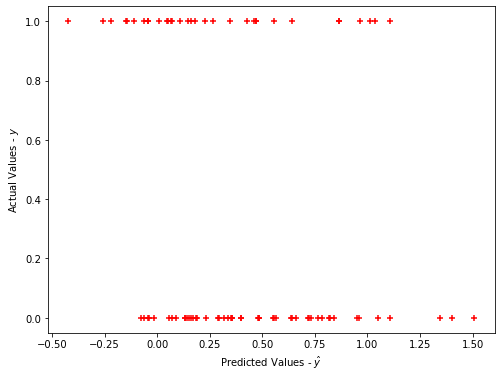

MSE: 0.5073458708802671


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          United States   R-squared (uncentered):                   0.812
Model:                            OLS   Adj. R-squared (uncentered):              0.797
Method:                 Least Squares   F-statistic:                              56.09
Date:                Mon, 20 Sep 2021   Prob (F-statistic):                    3.28e-14
Time:                        17:35:23   Log-Likelihood:                         -5.5209
No. Observations:                  42   AIC:                                      17.04
Df Residuals:                      39   BIC:                                      22.25
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
CPI score 2020     0.0093      0.003      2.972      0.005       0.003       0.016
2018 pfi          -0.0087      0.003     -3.442      0.001      -0.014      -0.004
GDP per capita   8.87e-06   5.08e-06      1.747      0.088    -1.4e-06    1.91e-05
==============================================================================
Omnibus:                        6.025   Durbin-Watson:                   2.213
Prob(Omnibus):                  0.049   Jarque-Bera (JB):                4.703
Skew:                           0.715   Prob(JB):                       0.0952
Kurtosis:                       3.802   Cond. No.                     2.27e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.27e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [54]:
regression('United States',data1[['CPI score 2020','2018 pfi','GDP per capita','United States']].dropna())

In [55]:
data1[['Country','CPI score 2020','2018 pfi','GDP per capita','Democracy Score','United States']]

Country  CPI score 2020  2018 pfi  \
0                              Denmark            88.0     13.99   
1                          New Zealand            88.0     13.62   
2                              Finland            85.0     10.26   
3                            Singapore            85.0     50.95   
4                               Sweden            85.0      8.31   
..                                 ...             ...       ...   
354                        Timor Leste             NaN       NaN   
355              Republic of the Congo             NaN       NaN   
356                         Micronesia             NaN       NaN   
357  Sovereign Military Order of Malta             NaN       NaN   
358               Trinidad and  Tobago             NaN       NaN   

     GDP per capita  Democracy Score  United States  
0      53549.700671             9.22            1.0  
1      39416.358733             9.26            1.0  
2      43402.863264             9.25            1.0  
3      52962.491569             6.02            1.0  
4      51949.271432             9.39            1.0  
..              ...              ...            ...  
354             NaN              NaN            0.0  
355             NaN             3.11            NaN  
356             NaN              NaN            1.0  
357             NaN              NaN            0.0  
358             NaN              NaN            0.0  

[359 rows x 6 columns]